# SVM

## Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
df = pd.read_csv("kddcup99_csv.csv", header=0)
print("rows of original dataset:", len(df))
print(df.head())
print("unique protocol_type:", df['protocol_type'].unique())
print("unique service:", df['service'].unique())
print("unique flag:", df['flag'].unique())
print("unique labels:", df['label'].unique())

rows of original dataset: 494020
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0       

## Preprocessing

In [3]:
# Get abnormal df
df_abnormal = df[df.iloc[:, -1] != 'normal']

# One-hot encode categorical features
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_abnormal[['protocol_type', 'service', 'flag']])

# Convert sparse matrix to a DataFrame and reset the index
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=encoder.get_feature_names_out())
df_encoded.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from df_abnormal
df_abnormal_dropped = df_abnormal.drop(columns=['protocol_type', 'service', 'flag']).reset_index(drop=True)

# Combine df_encoded (one-hot encoded) and df_abnormal_dropped (the rest of the columns)
df_filtered = pd.concat([df_abnormal_dropped, df_encoded], axis=1)

# Classify data into dos and not dos classes
DOS = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
df_filtered['dos'] = df_filtered['label'].apply(
    lambda x: 1 if x in DOS else -1
)

# Remove column "label"
df_filtered.drop(columns=['label'], inplace=True)

# Count number of dos and non-dos attacks
dos_num = (df_filtered['dos'] == 1).sum()
nondos_num = (df_filtered['dos'] == -1).sum()

# Display the filtered dataframe
print("Rows of filtered data:", len(df_filtered))
print(f"Number of dos: {dos_num}, number of non-dos: {nondos_num}")
print(df_filtered.head())

Rows of filtered data: 396743
Number of dos: 391458, number of non-dos: 5285
   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0       184       1511       2957     0               0       0    3   
1       305       1735       2766     0               0       0    3   
2        79        281       1301     0               0       0    2   
3        25        269       2333     0               0       0    0   
4         0          0          0     0               0       0    0   

   num_failed_logins  logged_in  lnum_compromised  ...  flag_RSTO  \
0                  0          1                 2  ...        0.0   
1                  0          1                 2  ...        0.0   
2                  0          1                 1  ...        0.0   
3                  0          1                 0  ...        0.0   
4                  0          0                 0  ...        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0

## Scale & Resample data

In [4]:
# Split the DataFrame into features (X) and target (y)
X = df_filtered.iloc[:, :-1]  # All columns except the last one (features)
y = df_filtered['dos']  # The 'dos' column (target)

# Scale the dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_filtered)

# Set up the resampling strategy
sampling_strategy = {label: int(min(dos_num,nondos_num)*0.5) for label in [-1,1]}

# Apply RandomUnderSampler with the strategy,
# majority and minority classes are equal, and their number is set to 50%
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Count number of dos and non-dos attacks
dos_num = (y_resampled == 1).sum()
nondos_num = (y_resampled == -1).sum()

# Display the resampled dataframe
print("Rows after resampled data:", len(X_resampled))
print(f"Number of dos: {dos_num}, number of non-dos attacks: {nondos_num}")

Rows after resampled data: 5284
Number of dos: 2642, number of non-dos attacks: 2642


## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

## Running SVM with Different Kernels

In [6]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    svm_model = SVC(kernel=kernel)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    print(f"Kernel: {kernel}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()

Kernel: linear
[[534   0]
 [  0 523]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       534
           1       1.00      1.00      1.00       523

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057


Kernel: poly
[[ 12 522]
 [  0 523]]
              precision    recall  f1-score   support

          -1       1.00      0.02      0.04       534
           1       0.50      1.00      0.67       523

    accuracy                           0.51      1057
   macro avg       0.75      0.51      0.36      1057
weighted avg       0.75      0.51      0.35      1057


Kernel: rbf
[[ 13 521]
 [  0 523]]
              precision    recall  f1-score   support

          -1       1.00      0.02      0.05       534
           1       0.50      1.00      0.67       523

    accuracy                           0.51      1057
   macro avg     

## Compare result and disscuss pros & cons on different kernels

As you can see in the result, linear kernel perform the best on the dataset no matter on percision or recall. Rbf and sigmoid perform bad.

**Linear Kernel:** Works well for linearly separable data, faster to train, but may struggle with complex decision boundaries.

**RBF Kernel:** Can handle non-linear data and complex patterns but is slower and computationally expensive.

**Polynomial Kernel:** Adds flexibility by allowing curved decision boundaries but introduces complexity in high-dimensional data.

**Sigmoid Kernel:** Similar to neural networks, but can perform poorly unless well-tuned.

## Using Two Features and Visualizing the Decision Boundary

              precision    recall  f1-score   support

          -1       0.93      0.97      0.95      2398
           1       0.97      0.93      0.95      2358

    accuracy                           0.95      4756
   macro avg       0.95      0.95      0.95      4756
weighted avg       0.95      0.95      0.95      4756



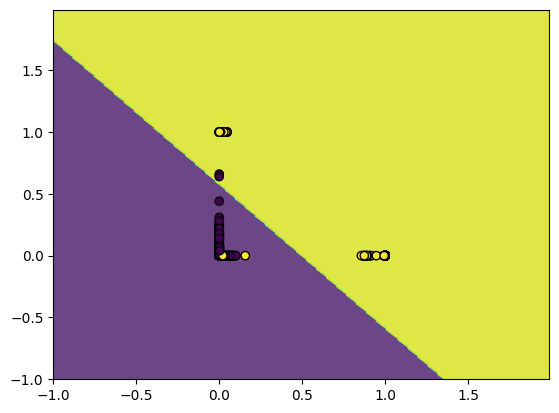

              precision    recall  f1-score   support

          -1       0.93      0.98      0.95      2398
           1       0.98      0.93      0.95      2358

    accuracy                           0.95      4756
   macro avg       0.95      0.95      0.95      4756
weighted avg       0.95      0.95      0.95      4756



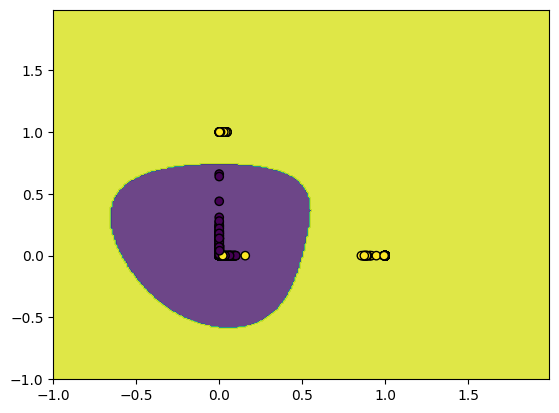

In [12]:
# Assume we selected two features from X
X_two_features = X_resampled[['srv_count', 'serror_rate']]
scaler = MinMaxScaler()
X_scaled_two = scaler.fit_transform(X_two_features)

# Further subsample
X_subsampled, X_test, y_subsampled, y_test = train_test_split(X_scaled_two, y_resampled, train_size=0.1, random_state=42)

# Function to visualize the decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.show()

kernels = ['linear', 'rbf']
for kernel in kernels:
    svm_model = SVC(kernel=kernel)
    svm_model.fit(X_subsampled, y_subsampled)
    y_pred = svm_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_decision_boundary(svm_model, X_subsampled, y_subsampled)

## Discuss result

using two feature `srv_count`, `serror_rate`, both kernel perform well on the dataset. The linear kernel sperate two class linearly, while rbf seperate it non-linearly. Linear kernel boundary is a straight line, while rbf kernel has curved, complex decision boundaries.